In [1]:
"""
3. 오토인코더
    (1) [이론]
        - 아주 간단하면서 강력한 비지도학습 딥러닝 모델
        - 기본적으로 입력값을 압축시킨 후, 다시 압축된 정보를 복원해서 입력값과 동일 출력값을 리턴하도록 학습, 학습과정을 통해 최대한 입력값과 출력값이 일치하도록 모델 파라미터가 최적화
        - 오토인코더의 압축된 정보는 입력값에서 노이즈가 제거된 핵심 특징들로 구성된 저차원 데이터로 간주, 차원축소의 목적으로 많이 활용
        - 오토인코더는 크게 인코더와 디코더로 구분, 그 사이에 압축된 정보 존재
        - 인코더와 디코더는 덴즈 레이어로 구성,인코더와 디코더 사이에 입력 원본값보다 작은 차원을 갖는 덴즈 레이어를 두어 정보 압축
"""

from IPython.display import Image
Image(url= "https://raw.githubusercontent.com/captainchargers/deeplearning/master/img/autoencoder1.png", width=500, height=250)


In [14]:
#(2) [실습] 손글씨 숫자 데이터 시각화 - MNIST 손글씨를 오토인코더를 활용해 차원축소 후 시각화
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np


In [3]:
# MNIST 데이터 획득
(x_train, y_train) , (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#MNIST 데이터 전처리
#학습 데이터
x_train = x_train.reshape(60000, 28*28)

#테스트 데이터 중 300개만 선택해서 테스트 데이터로 사용
x_test = x_test[:300]
y_test = y_test[:300]
x_test = x_test.reshape(300,784)

x_train = x_train.astype('float32') #텐서플로우는 부동소수점을 처리하므로 부동소수점으로 변환
x_test = x_test.astype('float32')

#데이터 정규화
gray_scale = 255
x_train /= gray_scale
x_test /= gray_scale

In [6]:
#모델구현

#입력
_input = tf.placeholder(tf.float32, [None, 28*28])
# encoder
encoder = tf.layers.dense(_input, 128, tf.nn.tanh)
# bottleneck
bottleneck = tf.layers.dense(encoder, 3)
# decoder
decoder = tf.layers.dense(bottleneck, 128, tf.nn.tanh)
#출력
_output = tf.layers.dense(decoder, 28*28, tf.nn.sigmoid)
# 손실함수
loss = tf.losses.mean_squared_error(labels = _input, predictions = _output)
# 최적화
train = tf.train.AdamOptimizer(0.002).minimize(loss)

In [12]:
#모델 학습

tf.set_random_seed(777)

init = tf.global_variables_initializer()

#하이어 파라미터 세팅
epoch_cnt = 10 #epoch는 처음부터 크게 잡지 말고 작게 잡은 다음 모델이 완전하게 돌아가는 것을 확인하면 적절히 세팅하는게 좋은듯
batch_size = 5000
iteration = len(x_train) // batch_size

#학습시작
with tf.Session() as sess:
    sess.run(init)
    print('train start...')
    for epoch in range(epoch_cnt):
        avg_loss = 0.0
        start = 0
        end = batch_size
        for i in range(iteration):
            _, loss_ = sess.run([train, loss], feed_dict = {_input : x_train[start:end]})
            start += batch_size
            end += batch_size
            #손실계산
            avg_loss += loss_/iteration
        print('epoch :' + str(epoch) + ', train loss :' + str(avg_loss))
    #battlenect에 존재하는 압축 벡터를 따로 저장
    _bottleneck = sess.run(bottleneck, {_input : x_test})



train start...
epoch :0, train loss :0.14532199191550413
epoch :1, train loss :0.07011101208627225
epoch :2, train loss :0.06789971453448136
epoch :3, train loss :0.06727164921661218
epoch :4, train loss :0.0661727755020062
epoch :5, train loss :0.06438222868988912
epoch :6, train loss :0.0627091433852911
epoch :7, train loss :0.06122744052360455
epoch :8, train loss :0.05973783228546381
epoch :9, train loss :0.05873361726601919


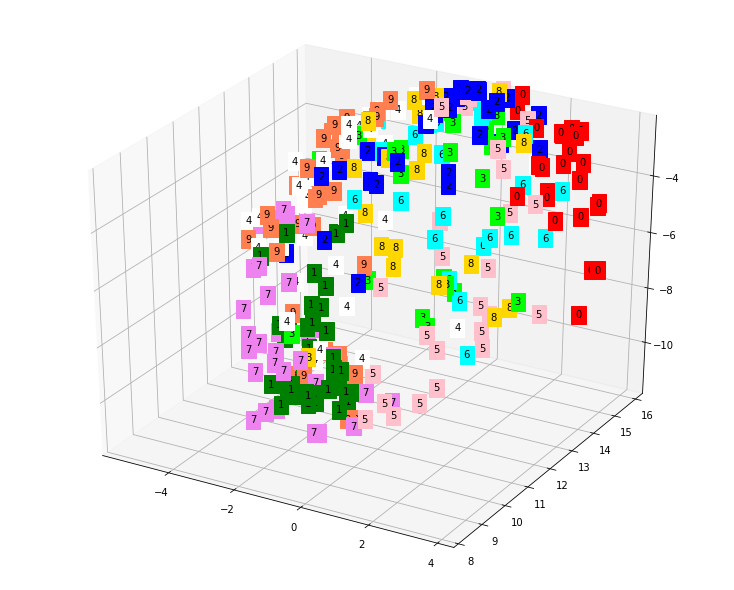

In [18]:
#데이터 시각화
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

fig = plt.figure(1)
ax = Axes3D(fig)

xs = _bottleneck[:, 0]
ys = _bottleneck[:, 1]
zs = _bottleneck[:, 2]

color = ['red', 'green', 'blue', 'lime', 'white', 'pink', 'aqua', 'violet', 'gold', 'coral']

for x, y, z, label in zip(xs, ys, zs, y_test):
    c = color[int(label)]
    ax.text(x, y, z, label, backgroundcolor=c)

ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(ys.min(), ys.max())
ax.set_zlim(zs.min(), zs.max())

plt.show()

In [ ]:
'''
4. Word2Vec
    (1)[이론] Word2Vec
        - word to vector의 줄임, 딥러닝 모델은 입력값으로 수치를 받기 때문에 자연어 처리에서 단어들을 어떻게 벡터로 받는지가 중요
        - 단어를 수치로 변환시키는데 사용되는 개념
    
        (i) 인코딩
            - 단어에 인덱스를 부여한 후 인덱스로 문장을 인코딩
            - ex) nice : 1, love : 2, you : 3일 때 nice -> [1], love you -> [2,3]
        
        (ii) 원핫인코딩
            - 단어를 원핫인코딩으로 변환할 때 각 단어들이 유사도 없는 독립적인 벡터가 되기 때문에 자연어 처리에서 많이 사용
            - ex) i: [1,0,0] , love : [0,1,0], you : [0,0,1]일 때,  i love you -> [[1,0,0],[0,1,0],[0,0,1]]
        
        (iii) 임베딩
            - 데이터의 특성을 유지한 채로 벡터 공간에 투영한 값
            - ex) 단어의 긍정, 부정 등을 구분
            
        (iv) Word2Vec
            - 비슷한 의미를 지닌 단어들이 벡터 공간에서 서로 이웃으로 존재하도록 변환하는 알고리즘
            - 스킵 그램(skip gram) 방식으로 각 단어별 레이블을 생성 후, 오토 인코더와 비슷한 딥러닝 모델 사용
            - 스킵 그램: 주변 단어들을 현재 단어의 레이블로 설정, word2vec 딥러닝 모델의 목점함수는 레이블과 현재 단어의 차이를 줄여나감으로써 최적화
            
'''

In [20]:
# 2.[실습] word2vec
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#데이터 획득
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

#불용어 제거 ; 불용어는 학습에 도움이 되지 않으면서 빈번하게 발생하는 단어
def remove_stop_words(corpus):
    stop_words = ['is','a','will','be']
    results = []
    
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

corpus = remove_stop_words(corpus)

In [21]:
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [23]:
#문장에 등장한 단어를 중복을 제거한 후 set에 담기
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

In [24]:
#단어별 인덱스 매핑 테이블 만들기
word2int = {}
for i, word in enumerate(words):
    word2int[word] = i

word2int

{'prince': 0,
 'wise': 1,
 'girl': 2,
 'man': 3,
 'queen': 4,
 'pretty': 5,
 'king': 6,
 'woman': 7,
 'boy': 8,
 'princess': 9,
 'young': 10,
 'strong': 11}

In [25]:
#스킵 그램방식으로 레이블 생성
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []


In [27]:
sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

In [28]:
for sentence in sentences:
    for idx,word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0): min(idx + WINDOW_SIZE, len(sentence)) +1]:
            if neighbor != word:
                data.append([word,neighbor])

In [29]:
data # window = 2 크기의 이웃하는 단어들끼리 묶임(스킵 그램 방식)

[['king', 'strong'],
 ['king', 'man'],
 ['strong', 'king'],
 ['strong', 'man'],
 ['man', 'king'],
 ['man', 'strong'],
 ['queen', 'wise'],
 ['queen', 'woman'],
 ['wise', 'queen'],
 ['wise', 'woman'],
 ['woman', 'queen'],
 ['woman', 'wise'],
 ['boy', 'young'],
 ['boy', 'man'],
 ['young', 'boy'],
 ['young', 'man'],
 ['man', 'boy'],
 ['man', 'young'],
 ['girl', 'young'],
 ['girl', 'woman'],
 ['young', 'girl'],
 ['young', 'woman'],
 ['woman', 'girl'],
 ['woman', 'young'],
 ['prince', 'young'],
 ['prince', 'king'],
 ['young', 'prince'],
 ['young', 'king'],
 ['king', 'prince'],
 ['king', 'young'],
 ['princess', 'young'],
 ['princess', 'queen'],
 ['young', 'princess'],
 ['young', 'queen'],
 ['queen', 'princess'],
 ['queen', 'young'],
 ['man', 'strong'],
 ['strong', 'man'],
 ['woman', 'pretty'],
 ['pretty', 'woman'],
 ['prince', 'boy'],
 ['prince', 'king'],
 ['boy', 'prince'],
 ['boy', 'king'],
 ['king', 'prince'],
 ['king', 'boy'],
 ['princess', 'girl'],
 ['princess', 'queen'],
 ['girl', 'prin

In [30]:
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head()

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king


In [31]:
#모델 구현

ONE_HOT_DIM = len(words)

#숫자를 원 핫 코딩으로 전환
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] #입력단어
Y = [] #레이블

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[x]))
    Y.append(to_one_hot_encoding(word2int[y]))


In [32]:
X

[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0.

In [38]:
#딥러닝 모델 입력값으로 전환
X_train = np.asarray(X)
Y_train = np.asarray(Y)

#입력값 및 레이블을 받기위한 placeholder설정
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

#시각화를 위해 임베딩을 2차원으로 설정
EMBEDDING_DIM = 2

#히든 레이어
W1 = tf.Variable(tf.truncated_normal([ONE_HOT_DIM, EMBEDDING_DIM], stddev = 0.1))
hidden_layer = tf.matmul(x,W1)

#출력 레이어
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add(tf.matmul(hidden_layer, W2), b2))

#손실함수
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis = [1]))

#최적화
train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

In [39]:
# 학습하기
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

iteration = 10000
for i in range(iteration):
    sess.run(train_op, feed_dict = {x : X_train, y_label : Y_train})
    if i % 10 ==0:
        print('iteration :' + str(i) + 'loss is :', sess.run(loss, feed_dict= {x : X_train, y_label : Y_train}))

iteration :0loss is : 2.501222
iteration :10loss is : 2.498587
iteration :20loss is : 2.4959886
iteration :30loss is : 2.493427
iteration :40loss is : 2.4909003
iteration :50loss is : 2.4884076
iteration :60loss is : 2.485949
iteration :70loss is : 2.4835227
iteration :80loss is : 2.4811285
iteration :90loss is : 2.478765
iteration :100loss is : 2.4764323
iteration :110loss is : 2.474129
iteration :120loss is : 2.471855
iteration :130loss is : 2.4696093
iteration :140loss is : 2.4673908
iteration :150loss is : 2.4651997
iteration :160loss is : 2.463035
iteration :170loss is : 2.4608958
iteration :180loss is : 2.4587822
iteration :190loss is : 2.4566932
iteration :200loss is : 2.454628
iteration :210loss is : 2.4525867
iteration :220loss is : 2.450568
iteration :230loss is : 2.448572
iteration :240loss is : 2.446598
iteration :250loss is : 2.4446454
iteration :260loss is : 2.4427142
iteration :270loss is : 2.4408033
iteration :280loss is : 2.4389126
iteration :290loss is : 2.4370418
ite

iteration :2500loss is : 2.1924756
iteration :2510loss is : 2.1916049
iteration :2520loss is : 2.190735
iteration :2530loss is : 2.1898665
iteration :2540loss is : 2.1889987
iteration :2550loss is : 2.1881316
iteration :2560loss is : 2.1872656
iteration :2570loss is : 2.1864
iteration :2580loss is : 2.1855357
iteration :2590loss is : 2.1846724
iteration :2600loss is : 2.1838098
iteration :2610loss is : 2.182948
iteration :2620loss is : 2.1820874
iteration :2630loss is : 2.1812274
iteration :2640loss is : 2.1803687
iteration :2650loss is : 2.1795106
iteration :2660loss is : 2.1786537
iteration :2670loss is : 2.1777976
iteration :2680loss is : 2.176942
iteration :2690loss is : 2.1760879
iteration :2700loss is : 2.1752343
iteration :2710loss is : 2.1743817
iteration :2720loss is : 2.1735303
iteration :2730loss is : 2.17268
iteration :2740loss is : 2.1718302
iteration :2750loss is : 2.1709814
iteration :2760loss is : 2.1701338
iteration :2770loss is : 2.169287
iteration :2780loss is : 2.16

iteration :4870loss is : 2.0183282
iteration :4880loss is : 2.0177584
iteration :4890loss is : 2.0171905
iteration :4900loss is : 2.016624
iteration :4910loss is : 2.0160584
iteration :4920loss is : 2.0154948
iteration :4930loss is : 2.0149329
iteration :4940loss is : 2.014372
iteration :4950loss is : 2.0138125
iteration :4960loss is : 2.0132546
iteration :4970loss is : 2.0126987
iteration :4980loss is : 2.0121436
iteration :4990loss is : 2.0115902
iteration :5000loss is : 2.0110383
iteration :5010loss is : 2.0104878
iteration :5020loss is : 2.0099387
iteration :5030loss is : 2.0093913
iteration :5040loss is : 2.008845
iteration :5050loss is : 2.0083003
iteration :5060loss is : 2.0077572
iteration :5070loss is : 2.0072153
iteration :5080loss is : 2.0066748
iteration :5090loss is : 2.006136
iteration :5100loss is : 2.0055985
iteration :5110loss is : 2.0050623
iteration :5120loss is : 2.0045278
iteration :5130loss is : 2.0039945
iteration :5140loss is : 2.0034628
iteration :5150loss is :

iteration :7240loss is : 1.9169292
iteration :7250loss is : 1.916605
iteration :7260loss is : 1.9162812
iteration :7270loss is : 1.9159582
iteration :7280loss is : 1.9156356
iteration :7290loss is : 1.9153135
iteration :7300loss is : 1.9149921
iteration :7310loss is : 1.9146714
iteration :7320loss is : 1.9143506
iteration :7330loss is : 1.9140311
iteration :7340loss is : 1.9137118
iteration :7350loss is : 1.913393
iteration :7360loss is : 1.9130747
iteration :7370loss is : 1.9127572
iteration :7380loss is : 1.9124401
iteration :7390loss is : 1.9121234
iteration :7400loss is : 1.9118074
iteration :7410loss is : 1.9114916
iteration :7420loss is : 1.9111769
iteration :7430loss is : 1.9108622
iteration :7440loss is : 1.9105484
iteration :7450loss is : 1.9102349
iteration :7460loss is : 1.9099221
iteration :7470loss is : 1.9096096
iteration :7480loss is : 1.9092977
iteration :7490loss is : 1.9089863
iteration :7500loss is : 1.9086753
iteration :7510loss is : 1.908365
iteration :7520loss is 

iteration :9650loss is : 1.8514998
iteration :9660loss is : 1.8512751
iteration :9670loss is : 1.8510506
iteration :9680loss is : 1.8508264
iteration :9690loss is : 1.8506029
iteration :9700loss is : 1.8503797
iteration :9710loss is : 1.8501567
iteration :9720loss is : 1.8499342
iteration :9730loss is : 1.8497119
iteration :9740loss is : 1.8494903
iteration :9750loss is : 1.849269
iteration :9760loss is : 1.8490478
iteration :9770loss is : 1.8488274
iteration :9780loss is : 1.848607
iteration :9790loss is : 1.8483872
iteration :9800loss is : 1.8481677
iteration :9810loss is : 1.8479487
iteration :9820loss is : 1.8477299
iteration :9830loss is : 1.8475115
iteration :9840loss is : 1.8472936
iteration :9850loss is : 1.8470758
iteration :9860loss is : 1.8468587
iteration :9870loss is : 1.8466418
iteration :9880loss is : 1.8464255
iteration :9890loss is : 1.8462094
iteration :9900loss is : 1.8459938
iteration :9910loss is : 1.8457786
iteration :9920loss is : 1.8455637
iteration :9930loss is

In [40]:
# word2vec 추출하기

# 학습이 완료된 모델에서 W1을 추출, W1이 우리가 찾고자 하는 word2vec 임베딩
# input이 one hot encoding이기 때문에 input에 W1를 곱하면 그 단어에 해당하는 W1값이 그대로 나옴 -> 즉 W값이 wrod2vec 임베딩

#히든 레이어의 값(word2vec) 저장
vectors = sess.run(W1)
print(vectors)

[[ 1.9032768  -0.36882433]
 [-1.1665182   1.1838019 ]
 [-0.54570115  0.91029215]
 [ 2.058965    0.03790882]
 [-0.63710093  0.20394711]
 [-1.3472015  -0.07516452]
 [ 1.0071796   0.1745732 ]
 [-0.15035492  0.47668657]
 [ 0.8031791  -0.28625363]
 [-0.2542041   1.4383798 ]
 [-0.16741127 -0.134656  ]
 [-0.1663467  -2.0988455 ]]


In [42]:
# word2vec의 좌푯값을 팬더스 데이터프레임으로 옮기기
w2v_df = pd.DataFrame(vectors, columns= ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]

In [43]:
w2v_df

,word,x1,x2
0,prince,1.903277,-0.368824
1,wise,-1.166518,1.183802
2,girl,-0.545701,0.910292
3,man,2.058965,0.037909
4,queen,-0.637101,0.203947
5,pretty,-1.347201,-0.075165
6,king,1.007180,0.174573
7,woman,-0.150355,0.476687
8,boy,0.803179,-0.286254
9,princess,-0.254204,1.438380


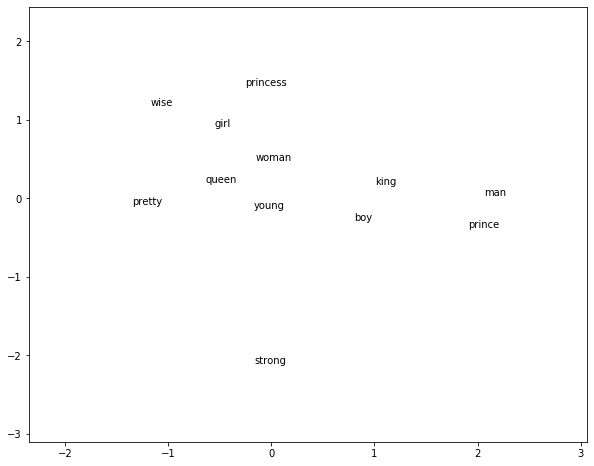

In [46]:
#word2vec 임베딩을 2차원 공간에 시각화하기
fig, ax = plt.subplots()

for word, x1, x2 in zip (w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show() #시각화를 통해 비슷한 의미의 단어들이 서로 가까운 위치에 있는 것을 확인